In [32]:
import pandas as pd
import matplotlib.pyplot as plt

In [33]:
df = pd.read_csv("online_retail_II.csv", encoding="ISO-8859-1")

In [34]:
print("Original shape:", df.shape)

Original shape: (1067371, 8)


In [35]:
df = df[df['Invoice'].notna()]

In [36]:
df = df[~df['Invoice'].astype(str).str.startswith('C')]

In [37]:
df = df.reset_index(drop=True)

In [38]:
print("Cleaned shape:", df.shape)

Cleaned shape: (1047877, 8)


In [39]:
print(df.head())

  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

           InvoiceDate  Price  Customer ID         Country  
0  2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3  2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4  2009-12-01 07:45:00   1.25      13085.0  United Kingdom  


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1047877 entries, 0 to 1047876
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1047877 non-null  object 
 1   StockCode    1047877 non-null  object 
 2   Description  1043495 non-null  object 
 3   Quantity     1047877 non-null  int64  
 4   InvoiceDate  1047877 non-null  object 
 5   Price        1047877 non-null  float64
 6   Customer ID  805620 non-null   float64
 7   Country      1047877 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 64.0+ MB


In [41]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [42]:
print(df.dtypes)

Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object


In [43]:
print(df['InvoiceDate'].head())
print(df['InvoiceDate'].dtype)

0   2009-12-01 07:45:00
1   2009-12-01 07:45:00
2   2009-12-01 07:45:00
3   2009-12-01 07:45:00
4   2009-12-01 07:45:00
Name: InvoiceDate, dtype: datetime64[ns]
datetime64[ns]


In [44]:
# Create TotalPrice
df['TotalPrice'] = df['Quantity'] * df['Price']

In [45]:
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

In [46]:
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'Invoice': 'nunique',                                    # Frequency
    'TotalPrice': 'sum'                                       # Monetary
})

# Rename columns
rfm.columns = ['Recency', 'Frequency', 'Monetary']

# Reset index (optional)
rfm = rfm.reset_index()

print(rfm.head())

   Customer ID  Recency  Frequency  Monetary
0      12346.0      326         12  77556.46
1      12347.0        2          8   5633.32
2      12348.0       75          5   2019.40
3      12349.0       19          4   4428.69
4      12350.0      310          1    334.40


In [47]:
rfm['R_score'] = pd.qcut(
    rfm['Recency'],
    5,
    labels=[5,4,3,2,1]   # reversed
)

In [48]:
rfm['F_score'] = pd.qcut(
    rfm['Frequency'].rank(method='first'),
    5,
    labels=[1,2,3,4,5]
)

In [49]:
rfm['M_score'] = pd.qcut(
    rfm['Monetary'],
    5,
    labels=[1,2,3,4,5]
)

In [50]:
rfm['RFM_Score'] = (
    rfm['R_score'].astype(str) +
    rfm['F_score'].astype(str) +
    rfm['M_score'].astype(str)
)

In [51]:
print(rfm.head())

   Customer ID  Recency  Frequency  Monetary R_score F_score M_score RFM_Score
0      12346.0      326         12  77556.46       2       5       5       255
1      12347.0        2          8   5633.32       5       4       5       545
2      12348.0       75          5   2019.40       3       4       4       344
3      12349.0       19          4   4428.69       5       3       5       535
4      12350.0      310          1    334.40       2       1       2       212


In [52]:
import re

def segment_customer(row):
    r = int(row['R_score'])
    f = int(row['F_score'])

    if r >= 4 and f >= 4:
        return 'Champions'
    elif r >= 3 and f >= 4:
        return 'Loyal Customers'
    elif r >= 4 and f <= 2:
        return 'New Customers'
    elif r == 3 and f == 3:
        return 'Potential Loyalists'
    elif r <= 2 and f >= 4:
        return 'At Risk'
    elif r <= 2 and f <= 2:
        return 'Lost'
    else:
        return 'Need Attention'

In [53]:
rfm['Segment'] = rfm.apply(segment_customer, axis=1)

In [54]:
rfm['Segment'].value_counts()

,count
Segment,
Lost,1525
Champions,1482
Need Attention,1293
Loyal Customers,516
New Customers,444
At Risk,354
Potential Loyalists,267


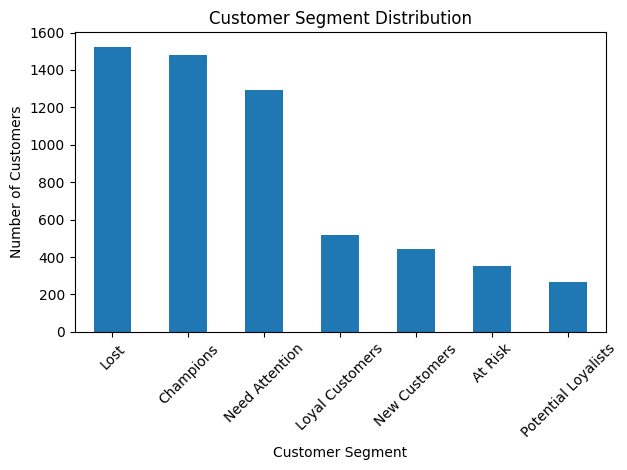

In [55]:
segment_counts = rfm['Segment'].value_counts()

plt.figure()
segment_counts.plot(kind='bar')

plt.xlabel("Customer Segment")
plt.ylabel("Number of Customers")
plt.title("Customer Segment Distribution")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()